# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
df= pd.read_csv('df7.csv', parse_dates=['Date'])
df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df 
# len(df)

,ds,y,tby,ffr,fta,eps,div,une,vix
0,2005-06-20,1216.10,4.11,3.04,812235.0,84.81,1.76,5.0,148.30
1,2005-06-21,1213.61,4.06,3.04,812235.0,84.81,1.76,5.0,149.00
2,2005-06-22,1213.88,3.95,3.04,811179.0,84.81,1.76,5.0,148.40
3,2005-06-23,1200.73,3.96,3.04,811179.0,84.81,1.76,5.0,150.50
4,2005-06-24,1191.57,3.92,3.04,811179.0,84.81,1.76,5.0,152.00
...,...,...,...,...,...,...,...,...,...
3893,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,25.85
3894,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,25.30
3895,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3,33.05
3896,2021-01-28,3787.38,1.07,0.09,7404926.0,95.72,1.58,6.3,30.49


In [3]:
df['div_une_vix'] = df['div'] * df['une'] * df['vix']

df = df.drop(columns=['ffr','div','une','vix'])

In [4]:
df

,ds,y,tby,fta,eps,div_une_vix
0,2005-06-20,1216.10,4.11,812235.0,84.81,1305.04000
1,2005-06-21,1213.61,4.06,812235.0,84.81,1311.20000
2,2005-06-22,1213.88,3.95,811179.0,84.81,1305.92000
3,2005-06-23,1200.73,3.96,811179.0,84.81,1324.40000
4,2005-06-24,1191.57,3.92,811179.0,84.81,1337.60000
...,...,...,...,...,...,...
3893,2021-01-25,3855.36,1.05,7414942.0,95.72,257.31090
3894,2021-01-26,3849.62,1.05,7414942.0,95.72,251.83620
3895,2021-01-27,3750.77,1.04,7404926.0,95.72,328.97970
3896,2021-01-28,3787.38,1.07,7404926.0,95.72,303.49746


In [5]:
from datetime import datetime
p = 0.9
# Train around 90% of dataset 
cutoff = int((p*len(df)//100)*100)
df_train = df[:cutoff].copy()
df_test = df.drop(df_train.index).copy()

print(df_train, df_test)

             ds        y   tby        fta     eps  div_une_vix
0    2005-06-20  1216.10  4.11   812235.0   84.81    1305.0400
1    2005-06-21  1213.61  4.06   812235.0   84.81    1311.2000
2    2005-06-22  1213.88  3.95   811179.0   84.81    1305.9200
3    2005-06-23  1200.73  3.96   811179.0   84.81    1324.4000
4    2005-06-24  1191.57  3.92   811179.0   84.81    1337.6000
...         ...      ...   ...        ...     ...          ...
3495 2019-06-20  2954.18  2.01  3844016.0  139.61     113.0220
3496 2019-06-21  2950.46  2.07  3844016.0  139.61     116.1810
3497 2019-06-24  2945.35  2.02  3844016.0  139.61     114.3558
3498 2019-06-25  2917.38  2.00  3844016.0  139.61     117.1638
3499 2019-06-26  2913.78  2.05  3826817.0  139.61     116.1810

[3500 rows x 6 columns]              ds        y   tby        fta     eps  div_une_vix
3500 2019-06-27  2924.92  2.01  3826817.0  139.61    113.02200
3501 2019-06-28  2941.76  2.00  3826817.0  139.61    110.21400
3502 2019-07-01  2964.33  2.03

In [15]:
pred_size = int((1-p)* len(df))


 Use prophet() to make predictions, we will split training as train_1 and train_2 with ratio 40% vs 60%, 
 train_1 will be used to fit prophet(), then predict on train_2.  Getting the predictions, feed the data into
 the Scenario 2 model, train again to get the parameters a,b,c,....

In [6]:
# #prophet part 
from fbprophet import Prophet
pred_size = int((1-p)* len(df))
fbp = Prophet(daily_seasonality=True)
# fit close price using fbprophet model
fbp.fit(tmp_train[['ds','y']])
    
 # predict pred_size futures and get the forecast price 
fut = fbp.make_future_dataframe(periods = pred_size,)
forecast = fbp.predict(fut) 
     

In [7]:
# forecast

In [8]:
df.columns

Index(['ds', 'y', 'tby', 'fta', 'eps', 'div_une_vix'], dtype='object')

In [9]:
possible_features = ['tby', 'fta', 'eps', 'div_une_vix']

In [10]:
# def powerset_no_empty(s):
#     power_set = []
#     x = len(s)
#     for i in range(1 << x):
#         power_set.append([s[j] for j in range(x) if (i & (1 << j))])
            
#     return power_set[1:]

# possible_features = powerset_no_empty(['tby', 'ffr', 'fta', 'eps', 'div'])

In [11]:
# print(len(possible_features))
# possible_features

In [12]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False, normalize=True, copy_X = True)
# reg.fit(df_train[possible_features], df_train['y'] - forecast[:cutoff].yhat)
reg.fit(df_train[possible_features], df_train['y'] )

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

In [13]:
coef = []
for i in range(len(possible_features)):
    coef.append(np.round(reg.coef_[i],5))

print(coef)

[144.0898, 0.00025, 6.85184, -0.31859]


In [16]:
pp_test = 0
pp_train = 0
for i in range(len(possible_features)):
    pp_test += coef[i] * df_test[df_test.columns[i+2]][:pred_size].ravel()
    pp_train += coef[i] * df_train[df_train.columns[i+2]].ravel()


In [24]:
df_test.y

3500    2924.92
3501    2941.76
3502    2964.33
3503    2973.01
3504    2995.82
         ...   
3893    3855.36
3894    3849.62
3895    3750.77
3896    3787.38
3897    3714.24
Name: y, Length: 398, dtype: float64

In [25]:
pd.Series(pp_test)

0      2166.902451
1      2166.356154
2      2174.422187
3      2168.730719
4      2163.000431
          ...     
384    2578.043832
385    2580.612541
386    2575.703084
387    2581.480514
388    2571.277179
Length: 389, dtype: float64

<AxesSubplot:>

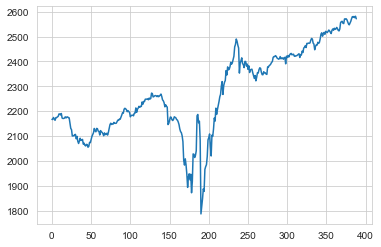

In [22]:
pd.Series(pp_test).plot()

In [20]:
from sklearn.metrics import mean_squared_error as MSE
# MSE for test data
# Actual close price: df_test[:test_time].y 
# Predicted price by prophet: pred_test
# Predicted price by tuning 
# mse1 = MSE(df_test[:test_time].y,pred_test) #
mse2 = MSE(df_test[:pred_size].y, pp_test)
print(mse2)

827319.5025292088


In [59]:
# MSE for train data
mse3 =MSE(df_train.y, forecast[:cutoff].yhat)
mse4 = MSE(df_train.y, pp_train)
print(mse3,mse4)

3648.6973797318233 3610.807848846896


In [26]:
pp_train2 = forecast[start:cutoff].yhat.copy() # predicted price on training data 
for i in range(len(possible_features)):
    pp_train2 += coef[i] * df_train[df_train.columns[i+2]][start:].ravel()

In [72]:
# start = 1000
# 67923.0178358458 61607.97389371774
# 19362.380200429267 15682.119546516684
# start = 2000
# 67923.0178358458 401430.42860662064
# 20880.437490361168 12449.74288604253


In [28]:
# df_train['pp']=pd.Series(np.append([np.nan for i in range(1000)], pp_train))

In [37]:
# plt.figure(figsize=(11,6))
# # plt.plot(range(1000,4000),df[1000:4000].fbsp,label='fb predicted price on test_data')
# plt.plot(range(1000,4000),df_train[1000:].pp,label="fitted values by our model")
# plt.plot(range(1000,4000), df_train[1000:].y   ,label='ture price value')
# plt.legend(fontsize=13)

# plt.title("Fitting on the training data",fontsize=18)

Text(0.5, 1.0, 'Prediction on the testing data')

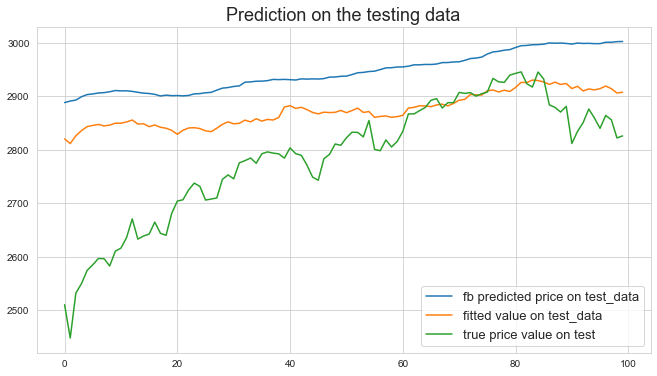

In [31]:
# plt.figure(figsize=(11,6))
# plt.plot(range(0,test_time),pd.Series(pred_test),label='fb predicted price on test_data')

# plt.plot(range(0,test_time),pd.Series(pp_test),label='fitted value on test_data')
# plt.plot(range(0,test_time),  df_test[:test_time].y,label='true price value on test')

# plt.legend(fontsize=13)
# plt.title("Prediction on the testing data",fontsize=18)

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=True, copy_X = True)

def get_X_y(df,features,target):
    # Returns X then y
    return np.array(df[features]), np.array(df[target])

from sklearn.metrics import mean_squared_error as MSE
def get_mse(model, X, y):
    # get the prediction
    pred = model.predict(X)
    
    # Returns the mse
    return MSE(pred,y)


X, y = get_X_y(df_train, possible_features, 'diff')
clone_reg = clone(reg)
clone_reg.fit(X,y)
pred_ = clone_reg.


mse = get_mse(clone_reg, X, y)



